Experiment to study how the model handles common gender nouns with different distributions, to test what is more important when predicting the gender, the context at inference time or distribution at train time.

Trains 20 models and outputs the average accuracy for each category of noun and context.

## Requirements

In [1]:
import json
from collections import defaultdict
from pcfg import PCFG
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pathlib
import tempfile
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from IPython.utils import io
import re
import os

In [2]:
device = 'cuda:0'

## Get vocabulary

In [3]:
with open('full_vocabulary.json', 'r') as openfile:
    full_vocab = json.load(openfile)

## Create train model PCFG

In [4]:
# Non-terminal productions
non_terminal_rules = """
S -> NP VP "."[1.0]

PP -> PREP NP [1.0]
VP -> VERB [0.5] | VERB NP [0.5]

NP -> NPGend [0.4] | NPAmb [0.4] | NP PP [0.20]

NPAmb -> DETEpic NOUN [0.4] | DETEpic ADJEpic NOUN [0.3] | DETEpic NOUN ADJEpic [0.3] 
NOUN -> NOUNMasc [0.35] | NOUNFem [0.35] | NOUN25 [0.1] | NOUN50 [0.1] | NOUN75 [0.1]

NPGend -> NPFem [0.35] | NPMasc [0.35] | NP25 [0.1] | NP50 [0.1] | NP75 [0.1]

NPFem -> DETFem NOUNFem [0.4] | DETFem ADJFem NOUNFem [0.3] | DETFem NOUNFem ADJFem [0.3] 
NPMasc -> DETMasc NOUNMasc [0.4] | DETMasc ADJMasc NOUNMasc [0.3] | DETMasc NOUNMasc ADJMasc [0.3] 

NP25 -> DETFem np25Fem [0.25] | DETMasc np25Masc [0.75]
np25Fem -> NOUN25 [0.4] | ADJFem NOUN25 [0.3] | NOUN25 ADJFem [0.3] 
np25Masc -> NOUN25 [0.4] | ADJMasc NOUN25 [0.3] | NOUN25 ADJMasc [0.3] 

NP50 -> DETFem np50Fem [0.50] | DETMasc np50Masc [0.50]
np50Fem -> NOUN50 [0.4] | ADJFem NOUN50 [0.3] | NOUN50 ADJFem [0.3] 
np50Masc -> NOUN50 [0.4] | ADJMasc NOUN50 [0.3] | NOUN50 ADJMasc [0.3] 

NP75 -> DETFem np75Fem [0.75] | DETMasc np75Masc [0.25]
np75Fem -> NOUN75 [0.4] | ADJFem NOUN75 [0.3] | NOUN75 ADJFem [0.3] 
np75Masc -> NOUN75 [0.4] | ADJMasc NOUN75 [0.3] | NOUN75 ADJMasc [0.3] 


"""

In [5]:
# Choose subset of full vocabulary to be used

nwords = {'VERB':20, 'ADJMasc':100, 'ADJFem':100, 'ADJEpic':100, 
          'PREP':5, 'DETEpic':5, 'DETMasc':5, 'DETFem':5,
          'NOUNMasc':140, 'NOUNFem':140, 'NOUN25':40, 'NOUN50':40, 'NOUN75':40}
        
train_vocab = {}

# convert to list  
for k in full_vocab:
    if k == 'NOUNEpic':
        train_vocab['NOUN25'] = full_vocab[k][:nwords['NOUN25']]
        train_vocab['NOUN50'] = full_vocab[k][nwords['NOUN25']:nwords['NOUN25']+nwords['NOUN50']]
        train_vocab['NOUN75'] = full_vocab[k][nwords['NOUN25']+nwords['NOUN50']:nwords['NOUN25']+nwords['NOUN50']+nwords['NOUN75']]
    else:
        train_vocab[k] = full_vocab[k][:nwords[k]]
 
for k in train_vocab:
    print(k, len(train_vocab[k]))

VERB 20
DETFem 5
DETMasc 5
DETEpic 5
PREP 5
NOUN25 40
NOUN50 40
NOUN75 40
NOUNFem 140
NOUNMasc 140
ADJFem 100
ADJMasc 100
ADJEpic 100


In [6]:
# Compute probability of each word

train_probs = defaultdict(lambda: dict()) # dictionary that maps non terminal symbols to dictionaries that map words to probabilities

for non_term in train_vocab:
    for k,w in enumerate(train_vocab[non_term]):
        N = len(train_vocab[non_term])
        k = k+1
        if k != N: 
            # following a zipfian distribution
            denominateur = sum(1/n for n in range(1,N+1))
            train_probs[non_term][w] = (1/k)/denominateur
        else: # last word
            train_probs[non_term][w] = 1 - sum(train_probs[non_term].values())
    assert sum(train_probs[non_term].values()) == 1.0 # probabilites of all terminals must add to 1


In [7]:
# Terminal productions
terminal_rules = "\n".join(f"{non_term} -> " + " | ".join(f'"{w}" [{train_probs[non_term][w]}]' for w in train_probs[non_term]) for non_term in train_probs)
train_model_rules = non_terminal_rules + terminal_rules

In [8]:
#print(train_model_rules)

In [ ]:
#train_grammar = PCFG.fromstring(train_model_rules)
#for sent in train_grammar.generate(20):
#    print(sent)

## Create train probe PCFG

In [10]:
# Non-terminal productions
train_probe_rules = """
S -> NP VP "."[1.0]

PP -> PREP NP [1.0]
VP -> VERB [0.5] | VERB NP [0.5]

NP -> NPGend [0.8] | NP PP [0.20]

NPGend -> NPFem [0.35] | NPMasc [0.35] | NP25 [0.1] | NP50 [0.1] | NP75 [0.1]

NPFem -> DETFem NOUNFem [0.4] | DETFem ADJFem NOUNFem [0.3] | DETFem NOUNFem ADJFem [0.3] 
NPMasc -> DETMasc NOUNMasc [0.4] | DETMasc ADJMasc NOUNMasc [0.3] | DETMasc NOUNMasc ADJMasc [0.3] 

NP25 -> DETFem np25Fem [0.25] | DETMasc np25Masc [0.75]
np25Fem -> NOUN25 [0.4] | ADJFem NOUN25 [0.3] | NOUN25 ADJFem [0.3] 
np25Masc -> NOUN25 [0.4] | ADJMasc NOUN25 [0.3] | NOUN25 ADJMasc [0.3] 

NP50 -> DETFem np50Fem [0.50] | DETMasc np50Masc [0.50]
np50Fem -> NOUN50 [0.4] | ADJFem NOUN50 [0.3] | NOUN50 ADJFem [0.3] 
np50Masc -> NOUN50 [0.4] | ADJMasc NOUN50 [0.3] | NOUN50 ADJMasc [0.3] 

NP75 -> DETFem np75Fem [0.75] | DETMasc np75Masc [0.25]
np75Fem -> NOUN75 [0.4] | ADJFem NOUN75 [0.3] | NOUN75 ADJFem [0.3] 
np75Masc -> NOUN75 [0.4] | ADJMasc NOUN75 [0.3] | NOUN75 ADJMasc [0.3] 


"""
# Only gendered contexts and nouns marked as U (unseen) are not used

In [11]:
train_probe_rules += terminal_rules

## Auxiliary functions

In [12]:
model_config = """
context_model : 'GPT' #one of 'RNN', 'LSTM', 'GPT'
model_input_size:  [256]
model_output_size: [256]
num_layers: [3]
max_vocab_size: 50000 #Gulordava setup
nheads : [4]  #for GPT only
ffn_hidden : [1024]   #for GPT only
tie_weights : True
dropout: [0.3]
epochs: [100]
batch_size: [64] 
bptt_chunk : [512]     #size of context for truncated BPTT
learning_rate: [0.0005]
warmup_epochs: [1]       #number of epochs for warmup
warmup_batch_size : [8]  #size of batches during warmup
restart_cycles: [4]      #number or warmup restarts for GPT only
positional : True        #use positional embeddings or ignore them
"""

In [13]:
def pos2label(pos):
    if 'DETFem' == pos:
        return 'Fem'
    if 'DETMasc' == pos:
        return 'Masc'
    #voluntarily undefined for other cases so it generates NaN values and I can use ffill

In [14]:
w2pos = {w: pos for pos in train_vocab for w in train_vocab[pos]}

In [15]:
def generate_model_data(directory_name, pcfg_rules, word_probabilities):
    train_grammar = PCFG.fromstring(pcfg_rules)

    train_data = '\n'.join(sent for sent in train_grammar.generate(10_000))
    with open(directory_name + "/train_model_data.txt", "w") as outfile:
        outfile.write(train_data)

    dev_data = '\n'.join(sent for sent in train_grammar.generate(1_000))
    with open(directory_name + "/dev_model_data.txt", "w") as outfile:
        outfile.write(dev_data)
    
    # Check for OOVs
    train_words = {word for word in train_data.split()}
    if not all(w in train_words for k in word_probabilities for w in word_probabilities[k]):
        generate_model_data(directory_name, pcfg_rules, word_probabilities)

In [16]:
def train_model(directory_name, model_config):
    # returns perplexity on dev set
    !mkdir {directory_name}/model
    with open(f"{directory_name}/model/model.yaml", "w") as f:
        f.write(model_config)
    cmd = f"python Lm4Ling/nnlm.py {directory_name}/model --train_file {directory_name}/train_model_data.txt --valid_file {directory_name}/dev_model_data.txt --device_name {device}"
    cmd_output = os.popen(cmd).read()
    return float(re.findall("Perplexity (.*)[\r|\n]", cmd_output)[0])

In [17]:
def generate_probe_data(directory_name, pcfg_rules):
    train_probe_grammar = PCFG.fromstring(pcfg_rules)
    with open(directory_name + "/train_probe_data.txt", "w") as outfile:
        outfile.write('\n'.join(sent for sent in train_probe_grammar.generate(1_000)))

In [19]:
def train_probe(directory_name):
    # returns the probe
    !python Lm4Ling/nnlm.py {directory_name}/model --probe_ex_file {directory_name}/train_probe_data.txt --out_pickle {directory_name}/probe_train_ex.pk --device_name {device}
    
    df_train = pd.read_pickle(f"{directory_name}/probe_train_ex.pk")
    df_train['pos'] = df_train['tokens'].apply(lambda w: w2pos.get(w,'NotFound'))
    df_train['labels'] = df_train['pos'].apply(pos2label).fillna(method='ffill')
    df_train = df_train[df_train.pos.str.startswith('NOUN')]
    X_train = df_train["vectors"].tolist()  
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    # Prepare labels    
    assert df_train['labels'].nunique(dropna=False) == 2 #check that every noun has a label
    y_train = df_train['labels'].tolist()

    # Train classifier
    classifier = LogisticRegression(penalty = 'l2', solver = 'saga', C=10)
    classifier.fit(X_train, y_train)

    return classifier, scaler

In [20]:
def generate_rules(noun_category, context, terminal_rules):
    # Produces the appropriate set of rules according to whether nouns should appear in a gendered or ambiguous context
    return f"""
    S -> NP VP "."[1.0]

    PP -> PREP NP [1.0]
    VP -> VERB [0.5] | VERB NP [0.5]

    NP -> NP{context} [0.80] | NP PP [0.20]

    NPAmb -> DETEpic NOUN [0.4] | DETEpic ADJEpic NOUN [0.3] | DETEpic NOUN ADJEpic [0.3] 
    NPFem -> DETFem NOUN [0.4] | DETFem ADJFem NOUN [0.3] | DETFem NOUN ADJFem [0.3] 
    NPMasc -> DETMasc NOUN [0.4] | DETMasc ADJMasc NOUN [0.3] | DETMasc NOUN ADJMasc [0.3]

    NOUN -> NOUN{noun_category} [1.0]

    
    """ + terminal_rules

In [21]:
def test_probe(directory_name, terminal_rules, w2pos, scaler, classifier, w2prob, error_data):
    for noun_category in ['Fem', 'Masc', '25', '50', '75']:
        for context in ['Fem', 'Masc', 'Amb']:
            test_rules = generate_rules(noun_category, context, terminal_rules).replace('    ', '')             
            test_grammar = PCFG.fromstring(test_rules)
            
            with open(directory_name + "/test_data.txt", "w") as outfile:
                outfile.write('\n'.join(sent for sent in test_grammar.generate(1_000)))
            
            with io.capture_output() as captured:
                !python Lm4Ling/nnlm.py {directory_name}/model --probe_ex_file {directory_name + "/test_data.txt"} --out_pickle {directory_name + "/test_ex.pk"} --device_name {device}
                            
            df_test = pd.read_pickle(directory_name + "/test_ex.pk")
            df_test['pos'] = df_test['tokens'].apply(lambda w: w2pos.get(w, 'NotFound'))
            df_test = df_test[df_test.pos.str.startswith('NOUN')]
            X_test = df_test["vectors"].tolist()  
            X_test = scaler.transform(X_test)
            
            y_hat_test = classifier.predict(X_test)
            error_data['prediction'] += list(y_hat_test)
            error_data['noun_category'] += [noun_category] * len(y_hat_test)
            error_data['context'] += [context] * len(y_hat_test)
            error_data['probability'] += df_test['tokens'].replace(w2prob).to_list()

# Main loop

In [ ]:
perplexities = []
error_data = {'noun_category': [], 'context': [], 'prediction': [], 'probability': []}
# remove the pos level of train_probs
w2prob = dict(element for subdict in train_probs.values() for element in subdict.items())

# do everything in a temp file
for i in range(20):
    print(f"-------------------------------- ITERATION {i} --------------------------------")
    with tempfile.TemporaryDirectory() as directory_name:
        #temp_dir = str(pathlib.Path(directory_name))
        # generate and save train and dev sets
        generate_model_data(directory_name, train_model_rules, train_probs)
        # train model and get perplexity
        perplexities.append(train_model(directory_name, model_config))
        # generate probe training data
        generate_probe_data(directory_name, train_probe_rules)
        # train probe and get gender distribution in data
        classifier, scaler = train_probe(directory_name)
        # test the probe for all configurations and get accuracies and confusion matrix for AUA
        test_probe(directory_name, terminal_rules, w2pos, scaler, classifier, w2prob, error_data)

In [ ]:
# Average perplexity over the 20 trained models
sum(perplexities)/len(perplexities)

23.1091245

In [ ]:
df = pd.DataFrame(error_data)
df

,noun_category,context,prediction,probability
0,Fem,Fem,Fem,0.181080
1,Fem,Fem,Fem,0.181080
2,Fem,Fem,Fem,0.001522
3,Fem,Fem,Fem,0.004643
4,Fem,Fem,Fem,0.181080
...,...,...,...,...
600060,75,Amb,Fem,0.006151
600061,75,Amb,Fem,0.011686
600062,75,Amb,Fem,0.233724
600063,75,Amb,Fem,0.233724


In [23]:
if not os.path.exists("results/exp_epicenes/"): 
    os.makedirs("results/exp_epicenes/") 

In [ ]:
df.to_json("results/exp_epicenes/df_raw_results.json")

## Analyse results

In [ ]:
df = pd.read_json("results/exp_epicenes/df_raw_results.json")
df

,noun_category,context,prediction,probability
0,Fem,Fem,Fem,0.181080
1,Fem,Fem,Fem,0.181080
2,Fem,Fem,Fem,0.001522
3,Fem,Fem,Fem,0.004643
4,Fem,Fem,Fem,0.181080
...,...,...,...,...
600060,75,Amb,Fem,0.006151
600061,75,Amb,Fem,0.011686
600062,75,Amb,Fem,0.233724
600063,75,Amb,Fem,0.233724


In [ ]:
df['feminine'] = df.prediction == 'Fem'
df['masculine'] = df.prediction == 'Masc'
df['context'] = df.context.replace({'Fem': 'feminine', 'Masc': 'masculine', 'Amb': 'ambiguous'})
df['noun_category'] = df.noun_category.replace({'Fem': 'feminine', 'Masc': 'masculine', 
                                          '25': '25% feminine', '50': '50% feminine', '75': '75% feminine'})

mean = pd.DataFrame({'feminine': df.groupby(['noun_category','context'])['feminine'].mean()*100,
              'masculine': df.groupby(['noun_category','context'])['masculine'].mean()*100})
ci = pd.DataFrame({'feminine': df.groupby(['noun_category','context'])['feminine'].sem()*1.96*100,
              'masculine': df.groupby(['noun_category','context'])['masculine'].sem()*1.96*100})

res = mean.combine(ci, lambda m, i: round(m, 2).astype('str') + ' ±' + round(i, 2).astype('str'))
#res.to_latex('results/exp2/epicenes.txt')
res


feminine    masculine
noun_category context                            
25% feminine  ambiguous  41.78 ±0.48  58.22 ±0.48
              feminine   99.95 ±0.02   0.05 ±0.02
              masculine     0.0 ±0.0   100.0 ±0.0
50% feminine  ambiguous   51.2 ±0.49   48.8 ±0.49
              feminine   99.99 ±0.01   0.01 ±0.01
              masculine   0.01 ±0.01  99.99 ±0.01
75% feminine  ambiguous  60.93 ±0.48  39.07 ±0.48
              feminine    100.0 ±0.0     0.0 ±0.0
              masculine   0.03 ±0.02  99.97 ±0.02
feminine      ambiguous   68.2 ±0.46   31.8 ±0.46
              feminine    100.0 ±0.0     0.0 ±0.0
              masculine   0.64 ±0.08  99.36 ±0.08
masculine     ambiguous  30.94 ±0.45  69.06 ±0.45
              feminine    98.89 ±0.1    1.11 ±0.1
              masculine     0.0 ±0.0   100.0 ±0.0

### Show results as a table

In [ ]:
df['feminine'] = df.prediction == 'Fem'
df['masculine'] = df.prediction == 'Masc'
df['context'] = df.context.replace({'Fem': 'feminine', 'Masc': 'masculine', 'Amb': 'ambiguous'})
df['noun_category'] = df.noun_category.replace({'feminine': 100, 'masculine': 0, '25% feminine': 25, '50% feminine': 50, '75% feminine': 75})
df


,noun_category,context,prediction,probability,feminine,masculine
0,100,feminine,Fem,0.181080,True,False
1,100,feminine,Fem,0.181080,True,False
2,100,feminine,Fem,0.001522,True,False
3,100,feminine,Fem,0.004643,True,False
4,100,feminine,Fem,0.181080,True,False
...,...,...,...,...,...,...
600060,75,ambiguous,Fem,0.006151,True,False
600061,75,ambiguous,Fem,0.011686,True,False
600062,75,ambiguous,Fem,0.233724,True,False
600063,75,ambiguous,Fem,0.233724,True,False


### Show results as a line graph

[Text(0.5, 0, 'Percentage of feminine occurrences in the training data'),
 Text(0, 0.5, 'Percentage of feminine probe preditions')]

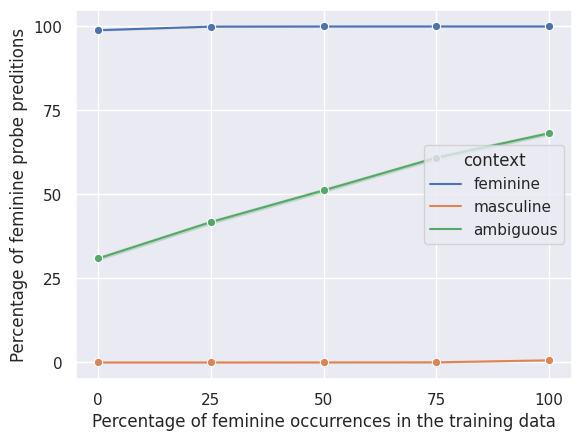

In [ ]:
sns.set(style="darkgrid")
g = sns.lineplot(data=df, 
            x='noun_category', 
            y='feminine', 
            hue='context',
            marker='o', 
            dashes=False,
            estimator='mean')

g.set_xticks([0, 25, 50, 75, 100])
g.set_xticklabels(['0','25','50','75','100'])
g.set_yticks([0, .25, .50, .75, 1])
g.set_yticklabels(['0','25','50','75','100'])
g.set(xlabel='Percentage of feminine occurrences in the training data',
      ylabel='Percentage of feminine probe preditions')

### Testing an alternative line graph

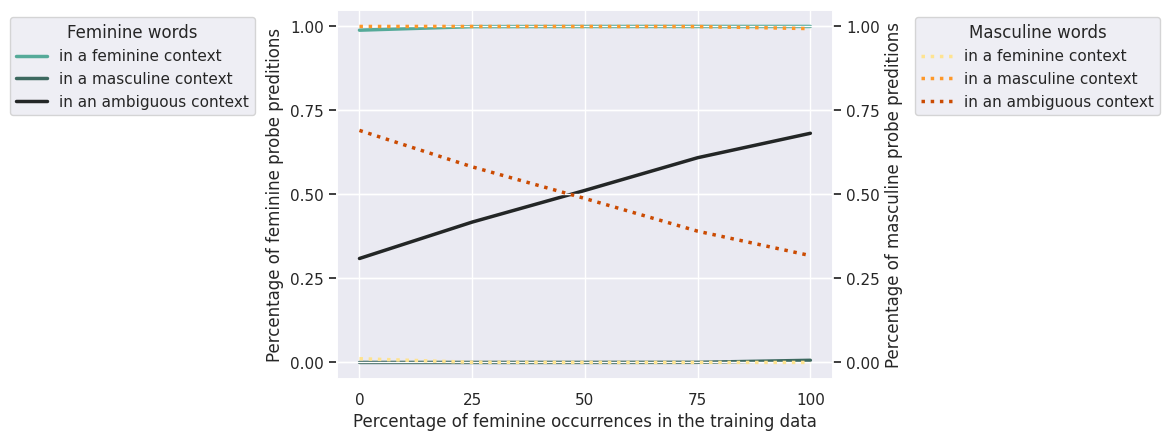

In [ ]:
import matplotlib.pyplot as plt
#sns.lineplot(data=df.column1, color="g")
#ax2 = plt.twinx()
#sns.lineplot(data=df.column2, color="b", ax=ax2)

sns.set(style="darkgrid")
sns.lineplot(data=df, 
            x='noun_category', 
            y='feminine', 
            errorbar=None,
            hue='context', 
            linewidth=2.5,
            style='context',
            dashes=False,
            estimator='mean',
            palette='dark:#5A9_r').set(xlabel='Percentage of feminine occurrences in the training data', 
                                       ylabel='Percentage of feminine probe preditions')
plt.legend(loc='upper right', 
           bbox_to_anchor=(-0.15, 1), 
           title='Feminine words', 
           labels=['in a feminine context', 'in a masculine context', 'in an ambiguous context'])

plt.yticks([0, .25, .50, .75, 1], ['0.00','0.25','0.50','0.75','1.00'])
ax2 = plt.twinx()

sns.lineplot(data=df, 
            x='noun_category', 
            y='masculine', 
            errorbar=None,
            hue='context', 
            style='context', 
            dashes=False,
            linestyle='dotted',
            #alpha=0.5,
            linewidth=2.5,
            estimator='mean',
            palette='YlOrBr',
            ax=ax2).set(ylabel='Percentage of masculine probe preditions')

plt.xticks([0, 25, 50, 75, 100], ['0','25','50','75','100'])
plt.yticks([0, .25, .50, .75, 1], ['0.00','0.25','0.50','0.75','1.00'])

plt.legend(loc='upper left', 
           bbox_to_anchor=(1.15, 1), 
           title='Masculine words', 
           labels=['in a feminine context', 'in a masculine context', 'in an ambiguous context'])
